Predictors: discovery day of wildfire, year of wildfire, latitude, and longitude of wildfire occurrence, wildfire cause, and state at which wildfire took place, annual average temperature of the state.
response variable: to predict the expected size class of the wildfire.

In [19]:
import pandas as pd
import numpy as np
columns_to_keep = ['FIRE_YEAR', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE', 'LATITUDE', 'LONGITUDE','STATE','FIRE_SIZE_CLASS']
data1= pd.read_csv("usa_wildfires_2006-2015.csv",usecols=columns_to_keep)
data2=pd.read_csv("climdiv_state_year.csv",usecols=['STATE','FIRE_YEAR','temp'])
data=data1.merge(data2, on=['STATE','FIRE_YEAR'], how='left')
data.head()

,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,temp
0,2006,73,4,C,45.537222,-111.587778,MT,44.375000
1,2008,99,9,A,44.566389,-83.993611,MI,44.033333
2,2006,1,7,B,35.668611,-94.280556,AR,61.991667
3,2006,2,7,C,34.799444,-94.725278,OK,62.158333
4,2006,4,7,B,33.746944,-94.589722,OK,62.158333


#### data preprocessing 

In [34]:
data.shape

(823514, 8)

In [2]:
data.isnull().any()

FIRE_YEAR          False
DISCOVERY_DOY      False
STAT_CAUSE_CODE    False
FIRE_SIZE_CLASS    False
LATITUDE           False
LONGITUDE          False
STATE              False
temp               False
dtype: bool

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = data.drop(['FIRE_SIZE_CLASS'], axis=1)  # Features
y = data['FIRE_SIZE_CLASS']  # Target variable

In [21]:
X['FIRE_YEAR'] = pd. to_numeric(X['FIRE_YEAR'])
X['DISCOVERY_DOY'] = pd. to_numeric(X['DISCOVERY_DOY'])
X['LATITUDE'] = pd. to_numeric(X['LATITUDE'])
X['LONGITUDE'] = pd. to_numeric(X['LONGITUDE'])
X['temp'] = pd. to_numeric(X['temp'])
#X['STAT_CAUSE_CODE' ]= X.STAT_CAUSE_CODE.astype(str)
X['STAT_CAUSE_CODE' ] = data.STAT_CAUSE_CODE.astype('category')
X['STATE' ] = data.STATE.astype('category')



In [ ]:
X.head

In [35]:
features_to_encode = X.columns[X.dtypes==object].tolist()  


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
col_trans = make_column_transformer(
                        (OneHotEncoder(),['STAT_CAUSE_CODE','STATE']),
                        (StandardScaler(),[ 'FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE','LONGITUDE','temp']),
                        remainder = "passthrough")

#,(StandardScaler(),[ 'FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE','LONGITUDE','temp'])

process the dataset

In [87]:
X.head()

,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,LATITUDE,LONGITUDE,STATE,temp
0,2006,73,4,45.537222,-111.587778,MT,44.375000
1,2008,99,9,44.566389,-83.993611,MI,44.033333
2,2006,1,7,35.668611,-94.280556,AR,61.991667
3,2006,2,7,34.799444,-94.725278,OK,62.158333
4,2006,4,7,33.746944,-94.589722,OK,62.158333


In [23]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, stratify = y, test_size=0.3)

SMOTE-NC

In [5]:

# Step 4: Handle class imbalance using resampling techniques (e.g., SMOTE)
from imblearn.over_sampling import SMOTENC

# Apply SMOTE to the dataset
smote_nc = SMOTENC(categorical_features=[2, 5], sampling_strategy='auto',random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

# Step 5: Split the data into training and testing sets


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)

### Random forest model

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model_forest = make_pipeline(col_trans, 
                             RandomForestClassifier(min_samples_leaf=100,
                                                    n_jobs=-1,                    
                      n_estimators=500,
                      bootstrap=True,
                      oob_score=True,
                      random_state=20))
model_forest.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['STAT_CAUSE_CODE', 'STATE']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['FIRE_YEAR', 'DISCOVERY_DOY',
                                                   'LATITUDE', 'LONGITUDE',
                                                   'temp'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=100, n_estimators=500,
                                        n_jobs=-1, oob_score=True,
                                        random_state=20))])

hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their potential values to search through
param_grid = {
    'randomforestclassifier__min_samples_leaf': [50, 100, 200],
    'randomforestclassifier__n_estimators': [100, 300, 500],
    # Add other hyperparameters you want to tune
}

# Create the GridSearchCV object with your model and hyperparameter grid
grid_search = GridSearchCV(model_forest, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters found during the search
best_params = grid_search.best_params_

# Get the best model trained with the best hyperparameters
best_model = grid_search.best_estimator_


#### Accuracy & Confusion Matrix

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
insample_predictions = model_forest.predict(X_train)
print("Random Forest Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

outsample_predictions = model_forest.predict(X_test)
print("Random Forest Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test)))
print(classification_report(outsample_predictions,y_test))

Random Forest Insample Accuracy 55.31%
              precision    recall  f1-score   support

           A       0.63      0.57      0.60    317849
           B       0.43      0.47      0.45    260182
           C       0.43      0.46      0.45    265398
           D       0.38      0.53      0.44    204346
           E       0.48      0.58      0.53    233633
           F       0.62      0.62      0.62    283017
           G       0.90      0.60      0.72    424877

    accuracy                           0.55   1989302
   macro avg       0.55      0.55      0.54   1989302
weighted avg       0.59      0.55      0.56   1989302

Random Forest Outsample Accuracy 54.49%
              precision    recall  f1-score   support

           A       0.63      0.56      0.59    135305
           B       0.42      0.46      0.44    111086
           C       0.43      0.46      0.44    114609
           D       0.37      0.52      0.43     87231
           E       0.47      0.57      0.51    100270

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

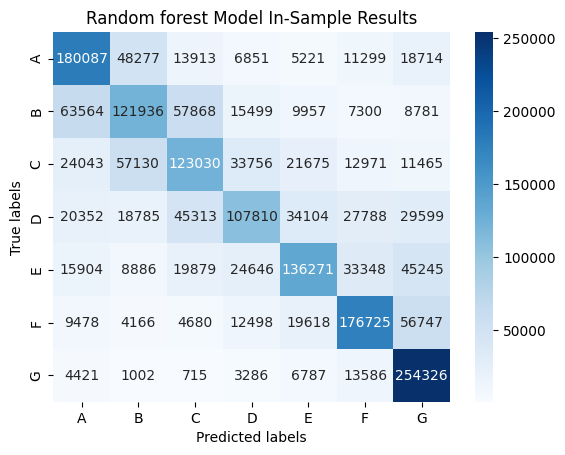

In [39]:
plot_confusion_matrix(y_train,insample_predictions,"Random forest Model In-Sample Results",['A', 'B'
                                                                                           ,'C','D',
                                                                                        'E','F','G'])

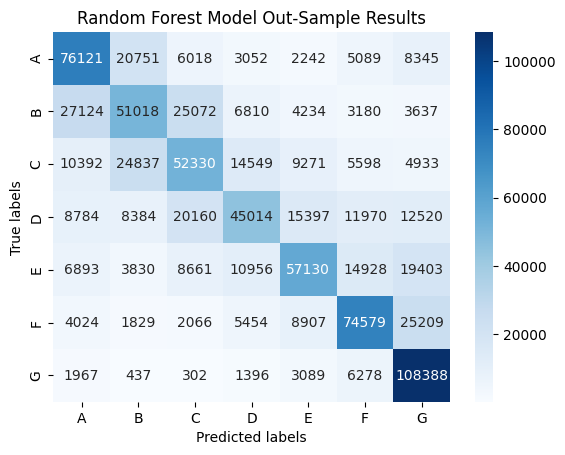

In [40]:
plot_confusion_matrix(y_test,outsample_predictions,"Random Forest Model Out-Sample Results",['A', 'B'
                                                                                                             ,'C','D',
                                                                                                             'E','F','G'])

  

-----------------------------------------------------------------------------------------------------------------------



-----------------------------------------------------------------------------------------------------------------------

### Logistic Model 

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
logistic_model = make_pipeline(col_trans,LogisticRegression(penalty='l2'))
model  = logistic_model.fit(X_train, y_train)

/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the hyperparameters and their potential values to search through
param_grid = {
    'logisticregression__C': [0.1, 1, 10],   # Inverse of regularization strength
    'logisticregression__penalty': ['l1', 'l2'],  # Regularization penalty type
    # Add other hyperparameters you want to tune
}

# Create the GridSearchCV object with your model and hyperparameter grid
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters found during the search
best_params = grid_search.best_params_

# Get the best model trained with the best hyperparameters
best_model = grid_search.best_estimator_


In [130]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
insample_predictions = model.predict(X_train)
print("Logistic regression Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))
outsample_predictions = model.predict(X_test2)
print("Logistic regression Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test2)))
print(classification_report(outsample_predictions,y_test2))


Logistic regression Insample Accuracy 34.17%
              precision    recall  f1-score   support

           A       0.51      0.41      0.46    348161
           B       0.34      0.36      0.35    263925
           C       0.35      0.36      0.35    274926
           D       0.15      0.26      0.19    158924
           E       0.21      0.23      0.22    250824
           F       0.21      0.25      0.23    235582
           G       0.64      0.40      0.49    456960

    accuracy                           0.34   1989302
   macro avg       0.34      0.33      0.33   1989302
weighted avg       0.39      0.34      0.36   1989302



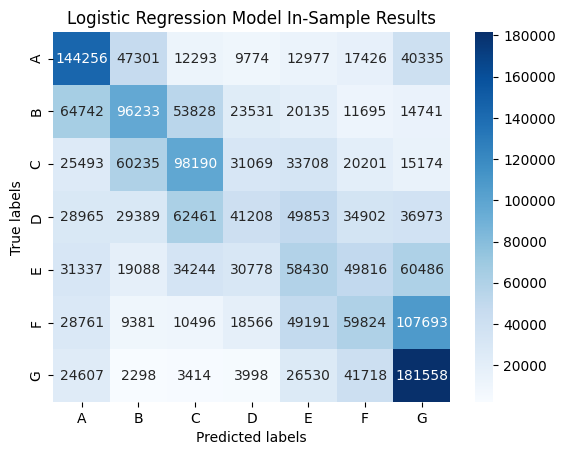

In [12]:
plot_confusion_matrix(y_train,insample_predictions,"Logistic Regression Model In-Sample Results",['A', 'B'
                                                                                                             ,'C','D',
                                                                                                             'E','F','G'])

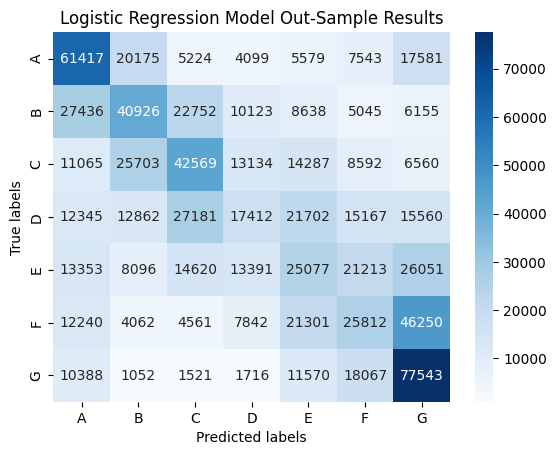

In [49]:
plot_confusion_matrix(y_test2,outsample_predictions,"Logistic Regression Model Out-Sample Results",['A', 'B'
                                                                                                             ,'C','D',
                                                                                                             'E','F','G'])

### KNN


In [ ]:
#knn
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.model_selection import GridSearchCV

#tuning using gridsearch

knn = KNeighborsClassifier()

leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
param_grid = {'n_neighbors': np.arange(1, 50)}
knn_gscv = GridSearchCV(knn, hyperparameters, cv=5)
model_knn1=  knn_gscv.fit(X_train,y_train)
 
print(knn_gscv.best_params_)

In [ ]:
insample_predictions = model_knn1.predict(X_train)
print("Logistic regression Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

outsample_predictions = model_knn1.predict(X_test)
print("Logistic regression Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test)))
print(classification_report(outsample_predictions,y_test))

### Decision Tree 

1. with smote-nc

In [51]:
from sklearn.pipeline import make_pipeline
from sklearn import tree
dt = tree.DecisionTreeClassifier(max_depth=200,min_samples_split=200,
                                  random_state = 20)
clf=make_pipeline(col_trans,dt)
clf = clf.fit(X_train, y_train)


hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the hyperparameters and their potential values to search through
param_grid = {
    'decisiontreeclassifier__max_depth': [50, 100, 200],  # Maximum depth of the tree
    'decisiontreeclassifier__min_samples_split': [50, 100, 200],  # Minimum samples required to split an internal node
    # Add other hyperparameters you want to tune
}

# Create the GridSearchCV object with your model and hyperparameter grid
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters found during the search
best_params = grid_search.best_params_

# Get the best model trained with the best hyperparameters
best_model = grid_search.best_estimator_


In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
insample_predictions = clf.predict(X_train)
print("decision tree Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

outsample_predictions = clf.predict(X_test)
print("decision tree Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test)))
print(classification_report(outsample_predictions,y_test))

decision tree Insample Accuracy 64.94%
              precision    recall  f1-score   support

           A       0.64      0.67      0.65    271350
           B       0.47      0.56      0.51    242446
           C       0.47      0.55      0.51    246650
           D       0.60      0.58      0.59    293724
           E       0.70      0.63      0.66    311488
           F       0.78      0.71      0.74    312475
           G       0.89      0.82      0.85    311169

    accuracy                           0.65   1989302
   macro avg       0.65      0.64      0.64   1989302
weighted avg       0.66      0.65      0.65   1989302

decision tree Outsample Accuracy 62.58%
              precision    recall  f1-score   support

           A       0.61      0.64      0.63    115237
           B       0.44      0.52      0.48    103999
           C       0.44      0.51      0.47    105995
           D       0.57      0.55      0.56    126378
           E       0.67      0.61      0.64    133089

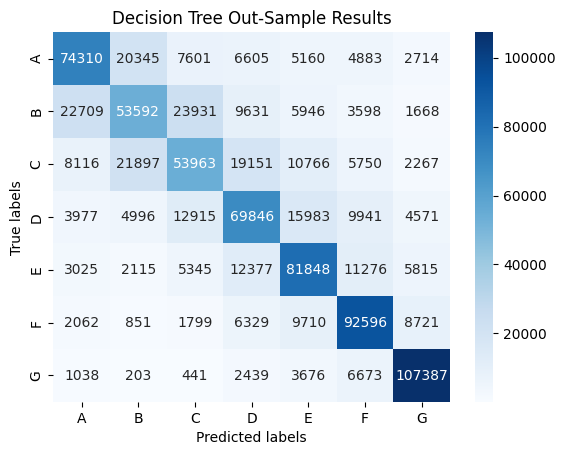

In [53]:
plot_confusion_matrix(y_test,outsample_predictions,"Decision Tree Out-Sample Results",['A', 'B'
                                        ,'C','D',
                                                                                                             'E','F','G'])

2. original dataset

In [17]:
clf2= make_pipeline(col_trans, tree.DecisionTreeClassifier(max_depth=50,min_samples_split=200,
                                  random_state = 20))
clf2 = clf.fit(X_train2, y_train2)

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
insample_predictions = clf2.predict(X_train2)
print("decision tree Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train2)))
print(classification_report(insample_predictions,y_train2))

outsample_predictions = clf2.predict(X_test2)
print("decision tree Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test2)))
print(classification_report(outsample_predictions,y_test2))

decision tree Insample Accuracy 66.03%
              precision    recall  f1-score   support

           A       0.69      0.70      0.70    202878
           B       0.80      0.65      0.72    349653
           C       0.16      0.46      0.23     22851
           D       0.02      0.47      0.03       370
           E       0.02      0.40      0.03       204
           F       0.01      0.33      0.02        81
           G       0.10      0.33      0.16       422

    accuracy                           0.66    576459
   macro avg       0.26      0.48      0.27    576459
weighted avg       0.73      0.66      0.69    576459

decision tree Outsample Accuracy 66.06%
              precision    recall  f1-score   support

           A       0.69      0.70      0.70     87098
           B       0.80      0.65      0.72    149544
           C       0.16      0.46      0.24      9946
           D       0.02      0.49      0.03       150
           E       0.01      0.31      0.03        93

xgbc


In [107]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded = le.fit_transform(y_train)
y_train[10:20]

382581     B
254334     B
2313477    F
2224192    F
2692057    G
759922     C
1320506    D
532604     B
502084     B
2595550    G
Name: FIRE_SIZE_CLASS, dtype: object

In [29]:
encoded[10:20]

array([1, 1, 5, 5, 6, 2, 3, 1, 1, 6])

In [30]:
import xgboost as xgb

xgbc=xgb.XGBClassifier(objective='multi:softprob',
                       learning_rate =0.6,
                        n_estimators= 800,
                        max_depth=8,
                        min_child_weight=0,
                        gamma=0.2,
                        subsample=0.9,
                        colsample_bytree=0.7,
                        nthread=40,
                        seed=230)
xgbc_model = make_pipeline(col_trans,xgbc)
xgbc_model.fit(X_train,encoded)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['STAT_CAUSE_CODE', 'STATE']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['FIRE_YEAR', 'DISCOVERY_DOY',
                                                   'LATITUDE', 'LONGITUDE',
                                                   'temp'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=Non...
                               feature_types=None, gamma=0.2, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.6,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None, min_child_weight=0,
                               missing=nan, monotone_constraints=None,
                               n_estimators=800, n_jobs=None, nthread=40,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

with hyperparameter tuning

In [112]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
new = xgb.XGBClassifier(objective='multi:softprob',
                       learning_rate =0.6,
                        min_child_weight=0,
                        gamma=0.2,
                        subsample=0.9,
                        colsample_bytree=0.7,
                        nthread=40,
                        seed=230)
param_test ={'n_estimators= 800':[700,800,900,600],
             'max_depth':[6,7,8],
             'min_child_samples': sp_randint(100, 500), 
             'gamma':[0.7,0.9,0.8]}
gs = RandomizedSearchCV(
    estimator=new, param_distributions=param_test, 
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)
newmodel = make_pipeline(col_trans,gs)
newmodel.fit(X_train, encoded)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [00:37:08] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:749: Invalid parameter "n_estimators= 800" contains whitespace.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001506e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001507f2468 xgboost::LearnerConfiguration::ValidateParameters() + 2400
  [bt] (2) 3   libxgboost.dylib                    0x00000001507e6228 xgboost::LearnerConfiguration::Configure() + 1196
  [bt] (3) 4   libxgboost.dylib                    0x00000001507e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x00000001506ff248 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.8.dylib                      0x00000001018ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001018a97d4 ffi_call_int + 1336
  [bt] (7) 8   _ctypes.cpython-39-darwin.so        0x000000010188c6d0 _ctypes_callproc + 1236
  [bt] (8) 9   _ctypes.cpython-39-darwin.so        0x0000000101886a80 PyCFuncPtr_call + 1176



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [00:37:09] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:749: Invalid parameter "n_estimators= 800" contains whitespace.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001506e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001507f2468 xgboost::LearnerConfiguration::ValidateParameters() + 2400
  [bt] (2) 3   libxgboost.dylib                    0x00000001507e6228 xgboost::LearnerConfiguration::Configure() + 1196
  [bt] (3) 4   libxgboost.dylib                    0x00000001507e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x00000001506ff248 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.8.dylib                      0x00000001018ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001018a97d4 ffi_call_int + 1336
  [bt] (7) 8   _ctypes.cpython-39-darwin.so        0x000000010188c6d0 _ctypes_callproc + 1236
  [bt] (8) 9   _ctypes.cpython-39-darwin.so        0x0000000101886a80 PyCFuncPtr_call + 1176



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [00:37:10] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:749: Invalid parameter "n_estimators= 800" contains whitespace.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001506e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001507f2468 xgboost::LearnerConfiguration::ValidateParameters() + 2400
  [bt] (2) 3   libxgboost.dylib                    0x00000001507e6228 xgboost::LearnerConfiguration::Configure() + 1196
  [bt] (3) 4   libxgboost.dylib                    0x00000001507e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x00000001506ff248 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.8.dylib                      0x00000001018ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001018a97d4 ffi_call_int + 1336
  [bt] (7) 8   _ctypes.cpython-39-darwin.so        0x000000010188c6d0 _ctypes_callproc + 1236
  [bt] (8) 9   _ctypes.cpython-39-darwin.so        0x0000000101886a80 PyCFuncPtr_call + 1176



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [00:37:11] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:749: Invalid parameter "n_estimators= 800" contains whitespace.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001506e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001507f2468 xgboost::LearnerConfiguration::ValidateParameters() + 2400
  [bt] (2) 3   libxgboost.dylib                    0x00000001507e6228 xgboost::LearnerConfiguration::Configure() + 1196
  [bt] (3) 4   libxgboost.dylib                    0x00000001507e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x00000001506ff248 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.8.dylib                      0x00000001018ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001018a97d4 ffi_call_int + 1336
  [bt] (7) 8   _ctypes.cpython-39-darwin.so        0x000000010188c6d0 _ctypes_callproc + 1236
  [bt] (8) 9   _ctypes.cpython-39-darwin.so        0x0000000101886a80 PyCFuncPtr_call + 1176



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [00:37:12] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:749: Invalid parameter "n_estimators= 800" contains whitespace.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001506e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001507f2468 xgboost::LearnerConfiguration::ValidateParameters() + 2400
  [bt] (2) 3   libxgboost.dylib                    0x00000001507e6228 xgboost::LearnerConfiguration::Configure() + 1196
  [bt] (3) 4   libxgboost.dylib                    0x00000001507e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x00000001506ff248 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.8.dylib                      0x00000001018ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001018a97d4 ffi_call_int + 1336
  [bt] (7) 8   _ctypes.cpython-39-darwin.so        0x000000010188c6d0 _ctypes_callproc + 1236
  [bt] (8) 9   _ctypes.cpython-39-darwin.so        0x0000000101886a80 PyCFuncPtr_call + 1176



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [00:37:13] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:749: Invalid parameter "n_estimators= 800" contains whitespace.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001506e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001507f2468 xgboost::LearnerConfiguration::ValidateParameters() + 2400
  [bt] (2) 3   libxgboost.dylib                    0x00000001507e6228 xgboost::LearnerConfiguration::Configure() + 1196
  [bt] (3) 4   libxgboost.dylib                    0x00000001507e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x00000001506ff248 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.8.dylib                      0x00000001018ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001018a97d4 ffi_call_int + 1336
  [bt] (7) 8   _ctypes.cpython-39-darwin.so        0x000000010188c6d0 _ctypes_callproc + 1236
  [bt] (8) 9   _ctypes.cpython-39-darwin.so        0x0000000101886a80 PyCFuncPtr_call + 1176



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [00:37:14] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:749: Invalid parameter "n_estimators= 800" contains whitespace.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001506e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001507f2468 xgboost::LearnerConfiguration::ValidateParameters() + 2400
  [bt] (2) 3   libxgboost.dylib                    0x00000001507e6228 xgboost::LearnerConfiguration::Configure() + 1196
  [bt] (3) 4   libxgboost.dylib                    0x00000001507e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x00000001506ff248 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.8.dylib                      0x00000001018ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001018a97d4 ffi_call_int + 1336
  [bt] (7) 8   _ctypes.cpython-39-darwin.so        0x000000010188c6d0 _ctypes_callproc + 1236
  [bt] (8) 9   _ctypes.cpython-39-darwin.so        0x0000000101886a80 PyCFuncPtr_call + 1176



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/mia/miniconda3/envs/zsz301/lib/python3.9/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [00:37:15] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:749: Invalid parameter "n_estimators= 800" contains whitespace.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001506e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001507f2468 xgboost::LearnerConfiguration::ValidateParameters() + 2400
  [bt] (2) 3   libxgboost.dylib                    0x00000001507e6228 xgboost::LearnerConfiguration::Configure() + 1196
  [bt] (3) 4   libxgboost.dylib                    0x00000001507e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x00000001506ff248 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.8.dylib                      0x00000001018ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001018a97d4 ffi_call_int + 1336
  [bt] (7) 8   _ctypes.cpython-39-darwin.so        0x000000010188c6d0 _ctypes_callproc + 1236
  [bt] (8) 9   _ctypes.cpython-39-darwin.so        0x0000000101886a80 PyCFuncPtr_call + 1176




In [90]:
trained_xgbc = xgbc_model.named_steps['xgbclassifier']

# Access the feature importances using the feature_importances_ attribute
feature_importances = trained_xgbc.feature_importances_

In [91]:
feature_importances

array([0.02604755, 0.00742929, 0.00851948, 0.01338331, 0.00947663,
       0.00432088, 0.0077929 , 0.01296672, 0.00785888, 0.01181315,
       0.00687526, 0.00593078, 0.0110524 , 0.0308449 , 0.0117319 ,
       0.01350647, 0.01278487, 0.02181668, 0.02201404, 0.00403296,
       0.00103272, 0.00118468, 0.01564603, 0.03393902, 0.00563339,
       0.01171012, 0.01253192, 0.00557073, 0.00360699, 0.02193507,
       0.02360473, 0.01316849, 0.004669  , 0.01315244, 0.00400778,
       0.00780748, 0.00830021, 0.01991697, 0.02081044, 0.0086784 ,
       0.03144985, 0.01188464, 0.01309587, 0.00442366, 0.00543944,
       0.01524237, 0.01280144, 0.16554663, 0.01180591, 0.0234749 ,
       0.0095555 , 0.0087354 , 0.01823591, 0.00233538, 0.01418225,
       0.01388453, 0.00822004, 0.01604599, 0.013354  , 0.00870148,
       0.00203964, 0.01246933, 0.03047102, 0.01414422, 0.0098517 ,
       0.00585615, 0.00714168, 0.00561806, 0.00861808, 0.00826926],
      dtype=float32)

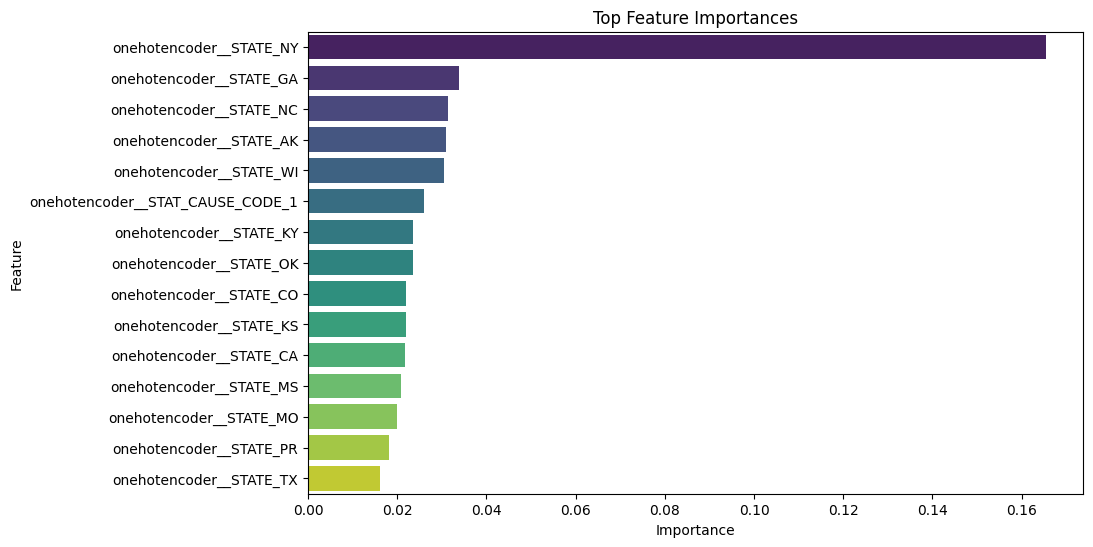

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have already fit the model and named it as xgbc_model

# Get the feature importances
feature_importances = xgbc_model.named_steps['xgbclassifier'].feature_importances_

# Create a DataFrame to hold feature importances
feature_importance_df = pd.DataFrame({'feature': col_trans.get_feature_names_out(),
                                      'importance': feature_importances})

# Sort the features by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Number of top features to display
num_top_features = 15

# Extract the top features and their importances
top_features = feature_importance_df.iloc[:num_top_features]
top_feature_names = top_features['feature']
top_feature_importances = top_features['importance']

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=top_feature_importances, y=top_feature_names, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importances')
plt.show()


use original dataset (without stonec transfrmation)

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
insample_predictions = le.inverse_transform(xgbc_model.predict(X_train))
print("xgbc Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))



xgbc Insample Accuracy 85.92%
              precision    recall  f1-score   support

           A       0.82      0.83      0.83    277764
           B       0.74      0.75      0.74    281496
           C       0.72      0.79      0.76    259184
           D       0.86      0.87      0.86    279951
           E       0.92      0.89      0.91    293426
           F       0.96      0.91      0.94    299664
           G       0.99      0.95      0.97    297817

    accuracy                           0.86   1989302
   macro avg       0.86      0.86      0.86   1989302
weighted avg       0.86      0.86      0.86   1989302

xgbc Outsample Accuracy 76.65%
              precision    recall  f1-score   support

           A       0.69      0.71      0.70    118712
           B       0.58      0.59      0.58    119712
           C       0.58      0.65      0.61    108482
           D       0.76      0.78      0.77    118747
           E       0.86      0.83      0.84    126158
           F     

In [54]:
outsample_predictions = le.inverse_transform(xgbc_model.predict(X_test))
print("xgbc Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test)))
print(classification_report(outsample_predictions,y_test))

xgbc Outsample Accuracy 76.65%
              precision    recall  f1-score   support

           A       0.69      0.71      0.70    118712
           B       0.58      0.59      0.58    119712
           C       0.58      0.65      0.61    108482
           D       0.76      0.78      0.77    118747
           E       0.86      0.83      0.84    126158
           F       0.92      0.86      0.89    130770
           G       0.97      0.91      0.94    129977

    accuracy                           0.77    852558
   macro avg       0.77      0.76      0.76    852558
weighted avg       0.77      0.77      0.77    852558



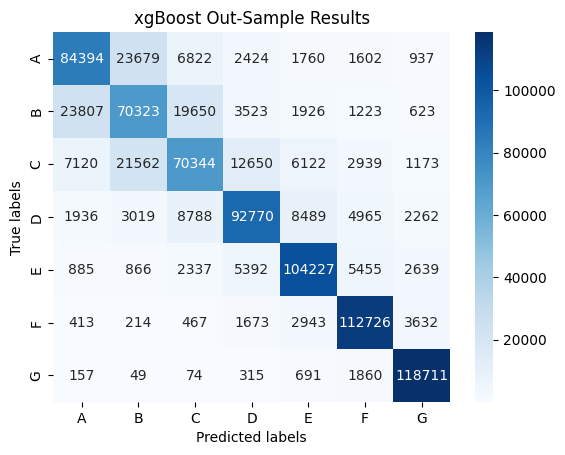

In [55]:
plot_confusion_matrix(y_test,outsample_predictions,"xgBoost Out-Sample Results",['A', 'B'
                                        ,'C','D',
                                                                                                             'E','F','G'])

In [59]:
y_prob = xgbc_model.predict_proba(X_test)

0
1
2
3
4
5
6


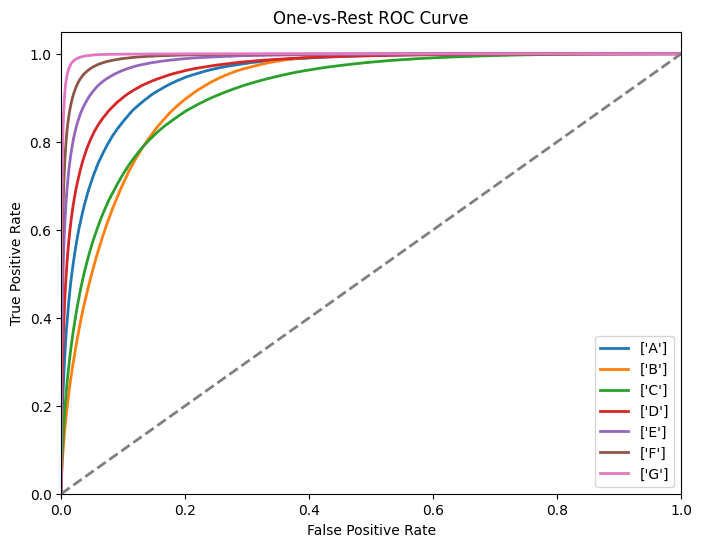

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
# Plot OvR ROC curve for each class
plt.figure(figsize=(8, 6))

# Compute ROC curve and ROC area for each class
fpr = [0,0,0,0,0,0,0]
tpr =  [0,0,0,0,0,0,0]
roc_auc =  [0,0,0,0,0,0,0]
for i in range(len(xgbc_model.classes_)):
    print(i)
    fpr[i], tpr[i], _ = roc_curve(le.fit_transform(y_test) == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
for i in range(len(xgbc_model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{le.inverse_transform([xgbc_model.classes_[i]])}')


# Plot random guessing line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()

### LightGBM


In [101]:
import lightgbm as lgb
lgb_model = make_pipeline(col_trans, lgb.LGBMClassifier(n_jobs=-1))
lgb_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['STAT_CAUSE_CODE', 'STATE']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['FIRE_YEAR', 'DISCOVERY_DOY',
                                                   'LATITUDE', 'LONGITUDE',
                                                   'temp'])])),
                ('lgbmclassifier', LGBMClassifier())])

In [102]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
insample_predictions = lgb_model.predict(X_train)
print("decision tree Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

outsample_predictions = lgb_model.predict(X_test)
print("decision tree Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions,y_test)))
print(classification_report(outsample_predictions,y_test))

decision tree Insample Accuracy 48.87%
              precision    recall  f1-score   support

           A       0.61      0.57      0.59    300712
           B       0.46      0.47      0.46    282218
           C       0.43      0.44      0.43    277835
           D       0.29      0.43      0.35    187964
           E       0.32      0.45      0.37    200746
           F       0.46      0.46      0.46    280119
           G       0.86      0.53      0.66    459708

    accuracy                           0.49   1989302
   macro avg       0.49      0.48      0.47   1989302
weighted avg       0.54      0.49      0.50   1989302

decision tree Outsample Accuracy 48.55%
              precision    recall  f1-score   support

           A       0.60      0.57      0.59    127867
           B       0.46      0.46      0.46    120617
           C       0.43      0.43      0.43    119724
           D       0.28      0.43      0.34     80548
           E       0.32      0.45      0.37     85954